# Kaggle Competition:  Iceberg or Ship

# resnext50 architecture (rest is Grover's options)
### see if log_loss=0.29 from resnet18 can be improved

In [1]:
!ls -l

total 2136
-rw-rw-r-- 1 ubuntu ubuntu 625023 Jan 14 18:47 1_getdata.ipynb
-rw-rw-r-- 1 ubuntu ubuntu 245619 Jan 14 18:36 2_model_resnet34.ipynb
-rw-rw-r-- 1 ubuntu ubuntu  13445 Jan 14 18:36 3_model_resnext50.ipynb
-rw-rw-r-- 1 ubuntu ubuntu  14220 Jan 13 21:14 4_model_nasnet.ipynb
-rw-rw-r-- 1 ubuntu ubuntu  64965 Jan 14 19:40 4_resnext_resize.ipynb
-rw-rw-r-- 1 ubuntu ubuntu 147077 Jan 14 19:42 5_resnet18_resize.ipynb
-rw-rw-r-- 1 ubuntu ubuntu 147134 Jan 14 19:44 6_resnext50_resize.ipynb
-rw-rw-r-- 1 ubuntu ubuntu 137540 Jan 14 18:36 baseline.ipynb
-rw-rw-r-- 1 ubuntu ubuntu    536 Jan 14 18:36 helper.py
-rw-rw-r-- 1 ubuntu ubuntu 767392 Jan 14 18:36 other_groverpr.ipynb
drwxrwxr-x 2 ubuntu ubuntu   4096 Jan 14 18:51 __pycache__
-rw-rw-r-- 1 ubuntu ubuntu    461 Jan 14 19:39 README.md


In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.imports import *

In [4]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import pandas as pd
import numpy as np
import shutil
from IPython.display import FileLink, FileLinks

from sklearn.model_selection import train_test_split
import helper

In [5]:
#PATH = "/home/nidhin/data/iceberg/"
PATH = os.path.expanduser("~/data/iceberg/")

In [6]:
!ls -l {PATH}

total 1973260
drwxrwxr-x  2 ubuntu ubuntu       4096 Jan  9 00:38 models
-rw-rw-r--  1 ubuntu ubuntu     117951 Oct 23 17:27 sample_submission.csv
-rw-rw-r--  1 ubuntu ubuntu      38566 Jan  7 20:36 sample_submission.csv.7z
drwxrwxr-x  2 ubuntu ubuntu     274432 Jan 14 18:44 test
-rw-rw-r--  1 ubuntu ubuntu 1521771850 Oct 23 17:27 test.json
-rw-rw-r--  1 ubuntu ubuntu  257127394 Jan  7 20:36 test.json.7z
drwxrwxr-x 45 ubuntu ubuntu       4096 Jan 14 18:51 tmp
drwxrwxr-x  4 ubuntu ubuntu       4096 Jan 14 18:43 train
-rw-rw-r--  1 ubuntu ubuntu  196313674 Oct 23 17:23 train.json
-rw-rw-r--  1 ubuntu ubuntu   44932785 Jan  7 20:36 train.json.7z
drwxrwxr-x  4 ubuntu ubuntu       4096 Jan 14 18:43 valid


In [7]:
np.random.seed(0)

## Set Architecture

In [8]:
arch=resnext50
sz=75
bs=32
lr = 1e-2

In [9]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.00)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs,test_name='test')
    return data

data = get_data(sz, bs)
data = data.resize(int(sz*1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [10]:
#tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
#data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs,test_name='test',)

learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

100%|██████████| 264/264 [00:17<00:00, 15.28it/s]


### Learning Rate Finder

In [11]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 61%|██████    | 25/41 [00:00<00:00, 57.98it/s, loss=3.54] 


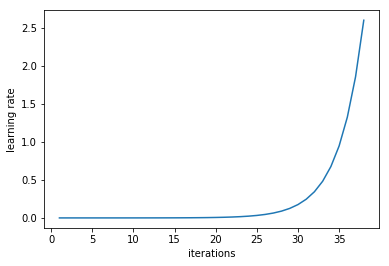

In [12]:
learn.sched.plot_lr()

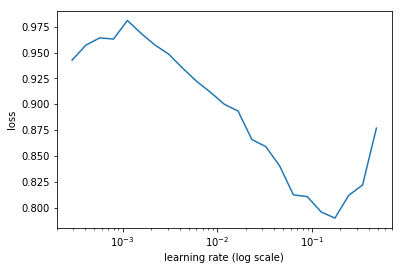

In [13]:
learn.sched.plot() 

In [14]:
learn.fit(lr, 8)
learn.precompute=False

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

[0.      0.63148 0.49687 0.71591]                          
[1.      0.52316 0.46574 0.73579]                          
[2.      0.50881 0.47736 0.8125 ]                          
[3.      0.44346 0.52311 0.73864]                          
[4.      0.40702 0.49164 0.73579]                          
[5.      0.41032 0.41383 0.83523]                          
[6.      0.39129 0.4498  0.84091]                          
[7.      0.37984 0.48039 0.82671]                          



### Stochastic Gradient Descent with Restart

In [15]:
#learn.fit(lr, 4, cycle_len=2)
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      0.52736 0.4316  0.80398]                          
[1.      0.50568 0.40859 0.83807]                          
[2.      0.47793 0.41686 0.80682]                          
[3.      0.49381 0.4621  0.78125]                          
[4.      0.4685  0.41905 0.81534]                          
[5.      0.46717 0.40806 0.81818]                          
[6.      0.44333 0.43367 0.80114]                          



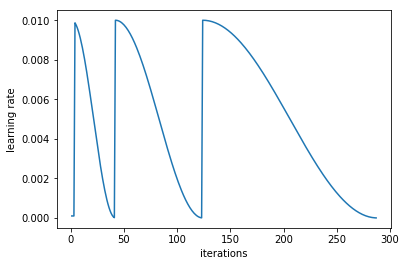

In [16]:
learn.sched.plot_lr()

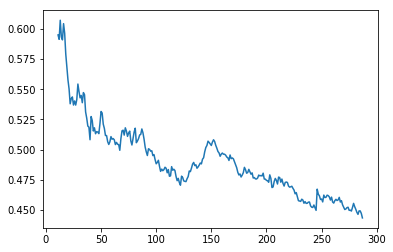

In [17]:
learn.sched.plot_loss()

In [ ]:
lr/10

In [ ]:
lr/9

In [ ]:
lr/3

In [ ]:
lr/4

### Unfreeze Layers

In [18]:
# unfreeze layers
learn.unfreeze()
#lrs = np.array([lr/15,lr/12,lr/9])
lrs = np.array([lr/9,lr/3,lr/1])

#wd = 0.025
#wds=[wd/100, wd/10, wd]
#wds=[0.0025,0.025,0.25]


In [19]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
#learn.fit(lrs, 5, cycle_len=1, cycle_mult=2,use_wd_sched=True,wds=wds)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      0.57173 0.37544 0.8125 ]                          
[1.      0.46852 0.319   0.84375]                          
[2.      0.4216  0.37089 0.82954]                          
[3.      0.44327 0.35393 0.81818]                          
[4.      0.39818 0.27858 0.87784]                          
[5.      0.37309 0.34977 0.87784]                          
[6.      0.32137 0.28579 0.87216]                          



In [20]:
learn.save('resnext50_sz75')

In [21]:
learn.load('resnext50_sz75')

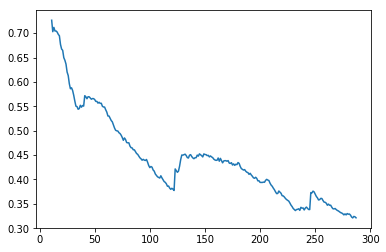

In [22]:
learn.sched.plot_loss()

In [23]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),axis=0)
(metrics.log_loss(y,preds), accuracy(preds,y))

(0.2727280071497432, 0.8691588785046729)

In [24]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      0.29739 0.25388 0.89773]                          
[1.      0.31191 0.28796 0.89204]                          
[2.      0.28412 0.26385 0.89204]                          
[3.      0.27975 0.26224 0.88068]                          
[4.      0.27783 0.27686 0.88921]                          
[5.      0.28858 0.25292 0.88352]                          
[6.      0.25265 0.27511 0.87784]                          



In [25]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      0.23223 0.23889 0.90057]                          
[1.      0.27451 0.25853 0.88636]                          
[2.      0.24057 0.276   0.88636]                          
[3.      0.24242 0.28228 0.875  ]                          
[4.      0.23523 0.30291 0.87784]                          
[5.      0.2119  0.25228 0.89204]                          
[6.      0.18577 0.24105 0.89204]                          



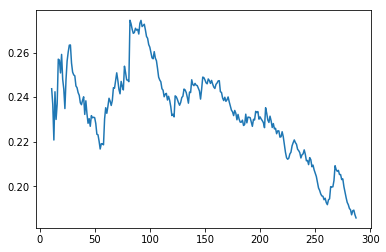

In [26]:
learn.sched.plot_loss()

## Log Loss; Accuracy (final model here)

In [27]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),axis=0)
(metrics.log_loss(y,preds), accuracy(preds,y))

(0.24804256874349564, 0.8940809968847352)

## Save predictions

In [ ]:
test_df = pd.read_json(PATH+"/test.json")
helper.make_test_file(log_preds,test_df,model_name='resnext50_sz75_zm13_bs32_comp_band',
                      classes=data.classes,
                      submission_folder =f'{PATH}sub'
                     )